In [1]:
import csv
from nltk import ngrams
import string
import re
import pickle as pkl
import numpy as np

In [2]:
data_val = []
with open('snli_val.tsv','r', encoding = 'utf-8', newline = '') as file:
    tsvreader = csv.reader(file, delimiter='\t')
    data_val = [line for line in tsvreader]
    
data_train = []
with open('snli_train.tsv','r', encoding = 'utf-8', newline = '') as file:
    tsvreader = csv.reader(file, delimiter='\t')
    data_train = [line for line in tsvreader]

In [3]:
print("Train dataset size is {}".format(len(data_train)))
print("Validation dataset size is {}".format(len(data_val)))

Train dataset size is 100001
Validation dataset size is 1001


In [5]:
data_val_s1, data_val_s2, data_val_label = zip(*data_val)
data_train_s1, data_train_s2, data_train_label = zip(*data_train)

In [6]:
data_val_s1 = data_val_s1[1:]
data_val_s2 = data_val_s2[1:]
data_val_label = data_val_label[1:]
data_train_s1 = data_train_s1[1:]
data_train_s2 = data_train_s2[1:]
data_train_label = data_train_label[1:]

In [7]:
len(data_val_label)

1000

In [8]:
"""
Tokenize data
"""
def tokenize_ngrams(sent):
    #tokens = ngrams(re.findall(r"[\w']+|[.,!?;():~@+-<>#]", sent.lower()),n)
    tokens = ngrams([gram for gram in re.findall(r"[\w']+|[.,!?;():~@+-<>#]*", sent.lower())
                     if (gram not in string.punctuation)], 1)
    return [token[0] for token in tokens]

def tokenize_dataset_ngrams(dataset):
    all_tokens = []
    token_dataset = []
    for sample in dataset:
        tokens = tokenize_ngrams(sample)
        token_dataset.append(tokens)
        all_tokens += tokens
    return token_dataset, all_tokens
    
def convert_labels(dataset_label):
    """Convert labels from number
       entails  --> 1
       contradiction --> -1
       neural --> 0
    """
    labels = []
    for l in dataset_label:
        if l == 'entailment':
            labels.append(2)
        elif l == 'contradiction':
            labels.append(0)
        elif l == 'neutral':
            labels.append(1)
        elif l=='label':
            labels.append('label')
    return labels
            

In [9]:
data_val_s1_tokens, _ = tokenize_dataset_ngrams(data_val_s1)
data_val_s2_tokens, _ = tokenize_dataset_ngrams(data_val_s2)
data_val_label0 = convert_labels(data_val_label)
data_train_s1_tokens, all_train_s1_tokens = tokenize_dataset_ngrams(data_train_s1)
data_train_s2_tokens, all_train_s2_tokens = tokenize_dataset_ngrams(data_train_s2)
data_train_label0 = convert_labels(data_train_label)

In [10]:
all_train_tokens = all_train_s1_tokens + all_train_s2_tokens
print("Total number of all tokens in train dataset is {}".format(len(all_train_tokens)))

Total number of all tokens in train dataset is 2037612


In [11]:
print(len(data_val_label0))

1000


In [12]:
data_val_tokens = list(zip(data_val_s1_tokens, data_val_s2_tokens, data_val_label0))
data_train_tokens = list(zip(data_train_s1_tokens, data_train_s2_tokens, data_train_label0))
pkl.dump(data_val_tokens, open("data_val_tokens.p", "wb"))
pkl.dump(data_train_tokens, open("data_train_tokens.p", "wb"))

In [13]:
pkl.dump(all_train_tokens, open("all_train_tokens.p", "wb"))

In [14]:
!ls

all_train_tokens.p   hw2_rnn_1-Copy1.ipynb  pre_emb_matrix
data_train_tokens.p  hw2_rnn_1.ipynb	    result
data_val_tokens.p    hw2_rnn_2.ipynb	    snli_train.tsv
hw2_cnn-Copy1.ipynb  mnli_train.tsv	    snli_val.tsv
hw2_cnn.ipynb	     mnli_val.tsv	    wiki-news-300d-1M.vec


In [15]:
"""Build Vocabulary"""
from collections import Counter

max_vocab_size = 20000
# save index 0 for unk and 1 for pad
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size-2))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [16]:
if len(token2id)< max_vocab_size:
    max_vocab_size = len(token2id)

In [17]:
print(len(token2id))

19581


In [18]:
"""Load pretrained embedding matrix"""

words_to_load = 200000

with open('wiki-news-300d-1M.vec', 'r', encoding = 'utf-8') as f:
    embedding_matrix = np.zeros([words_to_load, 300])
    word2id_emb = {}
    id2word_emb = []
    next(f)
    for i, line in enumerate(f):
        if i >= words_to_load: 
            break
        s = line.split()
        id2word_emb.append(s[0])
        word2id_emb[s[0]] = 0
        embedding_matrix[i] = np.asarray(s[1:])

print("Embedding_matrix shape is {}".format(embedding_matrix.shape))
print("Embedding Vocabualry size is {}".format(len(id2word_emb)))

Embedding_matrix shape is (200000, 300)
Embedding Vocabualry size is 200000


In [19]:
"""Build pretrained Embedding Matrix"""
pre_emb_matrix = np.zeros([max_vocab_size, 300])

i = 0
for word in id2token:
    try:
        id_pretrain = word2id_emb[word]
        pre_emb_matrix[token2id[word]] = embedding_matrix[id_pretrain]
    except KeyError:
        pre_emb_matrix[token2id[word]] = np.zeros(300)
        i = i+1
print("{} tokens appear in the pretrained dataset".format(1-i/max_vocab_size))

0.8282008069046525 tokens appear in the pretrained dataset


In [20]:
pre_emb_matrix.shape

(19581, 300)

In [21]:
pkl.dump(token2id, open("token2id.p", "wb"))
pkl.dump(id2token, open("id2token.p", "wb"))
pkl.dump(pre_emb_matrix, open("pre_emb_matrix", "wb"))

In [22]:
# convert token to id in the dataset
def token2index_dataset(tokens_data, token2id):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

In [23]:
data_val_s1_indices = token2index_dataset(data_val_s1_tokens, token2id)
data_val_s2_indices = token2index_dataset(data_val_s2_tokens, token2id)
data_train_s1_indices = token2index_dataset(data_train_s1_tokens, token2id)
data_train_s2_indices = token2index_dataset(data_train_s2_tokens, token2id)

In [24]:
len(data_val_s1_indices), len(data_train_s2_indices), len(data_train_label0)

(1000, 100000, 100000)

Create Dataset

In [25]:
from torch.utils.data import Dataset

In [26]:
class SNLIDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, data_list_s1, data_list_s2, data_label_list):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.s1_list, self.s2_list, self.label_list = data_list_s1, data_list_s2, data_label_list
        assert ((len(self.s1_list) == len(self.label_list)) and (len(self.s1_list) == len(self.s2_list)))

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        return [self.s1_list[key], self.s2_list[key], max(len(self.s1_list[key]), len(self.s2_list[key])), self.label_list[key]]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    s1_list = []
    s2_list = []
    label_list = []
    length_list = []

    for datum in batch:
        label_list.append(datum[3])
        length_list.append(datum[2])
    # padding
    #MAX_WORD_LENGTH
    max_length = max(length_list)
    for datum in batch:
        padded_vec_s1 = np.pad(np.array(datum[0]),
                                pad_width=((0,max_length-len(datum[0]))),
                                mode="constant", constant_values=0)
        padded_vec_s2 = np.pad(np.array(datum[1]),
                                pad_width=((0,max_length-len(datum[1]))),
                                mode="constant", constant_values=0)
        s1_list.append(padded_vec_s1)
        s2_list.append(padded_vec_s2)
    ind_dec_order = np.argsort(length_list)[::-1]
    s1_list = np.array(s1_list)[ind_dec_order]
    s2_list = np.array(s2_list)[ind_dec_order]
    length_list = np.array(length_list)[ind_dec_order]
    label_list = np.array(label_list)[ind_dec_order]
    return [torch.from_numpy(np.array(s1_list)), torch.from_numpy(np.array(s2_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]



In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

BATCH_SIZE = 32

In [28]:
train_dataset = SNLIDataset(data_train_s1_indices, data_train_s2_indices, data_train_label0)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = SNLIDataset(data_val_s1_indices, data_val_s2_indices, data_val_label0)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

In [155]:
n = 0
for s1, s2, length, label in train_loader:
    print('length of s1', len(s1))
    print('length of s2', len(s2))
    print(label)
    n = 1+n
    if n>3:
        break

length of s1 32
length of s2 32
tensor([0, 1, 2, 1, 0, 0, 0, 1, 1, 1, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 1, 1, 2, 2,
        2, 2, 1, 0, 2, 0, 2, 0])
length of s1 32
length of s2 32
tensor([1, 0, 1, 1, 0, 0, 0, 0, 1, 2, 0, 2, 2, 2, 1, 2, 1, 2, 1, 0, 1, 2, 2, 0,
        2, 1, 2, 2, 0, 0, 0, 0])
length of s1 32
length of s2 32
tensor([2, 1, 0, 2, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 0, 1, 0, 0, 0, 1, 0, 1,
        0, 2, 2, 1, 2, 0, 0, 0])
length of s1 32
length of s2 32
tensor([2, 2, 2, 0, 1, 0, 1, 2, 2, 0, 0, 0, 0, 0, 2, 0, 2, 1, 0, 2, 2, 1, 0, 2,
        1, 0, 0, 0, 0, 2, 2, 1])


In [62]:
train_dataset[0]

[[2, 21, 23, 4, 2, 101, 20, 30, 7, 2, 720, 1934, 2, 351, 10, 50],
 [2, 21, 23, 114, 3, 807, 78, 3, 50],
 16,
 0]

In [63]:
len(train_dataset)

100000

Build RNN model

bi-directional GRU

In [64]:
rnn = nn.RNN(10, 20,2)
input = torch.randn(5,3,10)
h0 = torch.randn(2,3,20)

In [68]:
input[:,0,:]

tensor([[-0.2706,  0.0511, -0.2846,  1.3676,  0.0936,  0.8250, -1.6942,  0.0878,
         -4.1304, -1.5029],
        [ 0.4704, -0.9433, -0.0144, -0.3048, -0.1974,  1.0391,  1.0443,  1.4158,
          2.2376, -2.0218],
        [-1.4847, -0.1551,  1.5994,  0.0388,  0.7863, -0.0203, -0.1791, -0.4830,
         -0.7885,  1.0997],
        [ 1.6072,  0.6304,  0.4567,  0.8326,  0.2975,  1.0990,  0.4029,  0.6755,
         -0.2011, -0.8112],
        [-0.6082, -0.5086, -0.0764,  0.6497, -0.4813, -0.2656, -0.3421,  0.1383,
          1.7226, -0.1734]])

In [70]:
output, h1 = rnn(input, h0)
output.shape, h1.shape

(torch.Size([5, 3, 20]), torch.Size([2, 3, 20]))

In [72]:
torch.sum(output, dim = 0).shape

torch.Size([3, 20])

In [78]:
torch.cat((input, output), dim =-1).shape

torch.Size([5, 3, 30])

In [29]:
class GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size, pretrained_weight):
        """
        GRU accepts the following hyperparams:
        input_size - The number of expected features of in the input x
        hidden_size - The number of features in the hidden state h
        num_layers - Here we use the Default:1
        bias - True
        batch_first - The input and output tensors are provided as (batch, seq, feature)
        bidirectional - 
        ===================================================================================
        Note: padding_idx = 0
        """
        super(GRU, self).__init__()
        
        layer_size2 = 20
        #layer_size2 = 200
        
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx = 0)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weight))
        self.gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional = True) # The first dimension is the batch dimension
        self.linear1 = nn.Linear(4*hidden_size, layer_size2)
        self.linear2 = nn.Linear(layer_size2, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(2*self.num_layers, batch_size, self.hidden_size)

        return hidden.to(device)

    def forward(self, s1, s2, lengths):
        # reset hidden state
        batch_size, seq_len = s1.size()

        self.hidden_s1 = self.init_hidden(batch_size)
        self.hidden_s2 = self.init_hidden(batch_size)
        
        embed_s1 = self.embedding(s1)
        embed_s2 = self.embedding(s2)
    
        rnn_out_s1, self.hidden_s1 = self.gru(embed_s1, self.hidden_s1)
        rnn_out_s2, self.hidden_s2 = self.gru(embed_s2, self.hidden_s2)
        
        rnn_out_s1 = torch.sum(rnn_out_s1, dim=1)
        rnn_out_s2 = torch.sum(rnn_out_s2, dim=1)
        
        rnn_out = torch.cat((rnn_out_s1, rnn_out_s2),-1)
        
        rnn_out = self.linear1(rnn_out)
        rnn_out = F.relu(rnn_out)
        logits = self.linear2(rnn_out)
        
        return logits



In [30]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for s1, s2, lengths, labels in loader:
        s1_batch, s2_batch, lengths_batch, label_batch = s1.to(device), s2.to(device), lengths.to(device), labels.to(device)
        outputs = F.softmax(model(s1_batch, s2_batch, lengths_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += label_batch.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return (100 * correct / total)



In [31]:
def test_model2(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    total_loss = 0
    criterion_test = nn.CrossEntropyLoss()
    
    model.eval()
    for s1, s2, lengths, labels in loader:
        s1_batch, s2_batch, lengths_batch, label_batch = s1.to(device), s2.to(device), lengths.to(device), labels.to(device)
        probability = model(s1_batch, s2_batch, lengths_batch)
        loss_test = float(criterion_test(probability, label_batch))
        total_loss += loss_test
        outputs = F.softmax(probability, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]

        total += label_batch.size(0)
        correct += predicted.eq(label_batch.view_as(predicted)).sum().item()
    return (100 * correct / total), total_loss/len(loader)

In [32]:
acc0 = test_model(val_loader, model)
acc0

NameError: name 'model' is not defined

In [ ]:
acc1, loss1 = test_model2(val_loader, model)

In [ ]:
acc1

In [ ]:
loss1

In [ ]:
type(pre_emb_matrix)

In [128]:
len(id2token), pre_emb_matrix.shape

(19581, (19581, 300))

In [44]:
HIDDEN_SIZE = 800
result_FILE = 'result/rnn_hs'+str(HIDDEN_SIZE) +'.p'
figname = 'result/rnn_acc_hs'+str(HIDDEN_SIZE)  +'.pdf'
model_name = 'result/model_rnn_hs'+str(HIDDEN_SIZE) +'.pt'
result_FILE, figname, model_name

('result/rnn_hs800.p', 'result/rnn_acc_hs800.pdf', 'result/model_rnn_hs800.pt')

In [45]:
model = GRU(emb_size=300, hidden_size=HIDDEN_SIZE, num_layers=1, num_classes=3, 
            vocab_size=len(id2token), pretrained_weight = pre_emb_matrix).to(device)

In [46]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

11227983


In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [29]:
result_FILE = 'result/rnn_hs100.p'

In [32]:
best_val_acc = 0

In [35]:
learning_rate = 3e-4
num_epochs = 10 # number epoch to train

val_acc_record = []
#train_acc_record = []
val_loss_record = []
#train_loss_record = []
step_record = []

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (s1, s2, lengths, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1.to(device), s2.to(device), lengths.to(device))
        loss = criterion(outputs, labels.to(device))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 300 == 0:
            # validate
            val_acc, val_loss = test_model2(val_loader, model)
            val_acc_record.append(val_acc)
            val_loss_record.append(val_loss)
            #train_acc, train_loss = test_model2(train_loader, model)
            #train_acc_record.append(train_acc)
            #train_loss_record.append(train_loss)
            step_record.append( i + epoch * total_step)
            print('Epoch: [{}/{}], Step: [{}/{}], Val_Acc: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc))
            if val_acc > best_val_acc:
                with open(model_name, 'wb') as f:
                    torch.save(model, f)
                    best_val_loss = val_loss

#training_curve = zip(step_record, train_acc_record, train_loss_record, val_acc_record, val_loss_record)
#pkl.dump(training_curve, open(result_FILE, "wb"))

Epoch: [1/10], Step: [301/3125], Val_Acc: 42.0
Epoch: [1/10], Step: [601/3125], Val_Acc: 46.5
Epoch: [1/10], Step: [901/3125], Val_Acc: 47.6
Epoch: [1/10], Step: [1201/3125], Val_Acc: 51.6
Epoch: [1/10], Step: [1501/3125], Val_Acc: 50.1
Epoch: [1/10], Step: [1801/3125], Val_Acc: 50.1
Epoch: [1/10], Step: [2101/3125], Val_Acc: 51.2
Epoch: [1/10], Step: [2401/3125], Val_Acc: 51.2
Epoch: [1/10], Step: [2701/3125], Val_Acc: 54.8
Epoch: [1/10], Step: [3001/3125], Val_Acc: 55.7
Epoch: [2/10], Step: [301/3125], Val_Acc: 57.8
Epoch: [2/10], Step: [601/3125], Val_Acc: 60.4
Epoch: [2/10], Step: [901/3125], Val_Acc: 61.3
Epoch: [2/10], Step: [1201/3125], Val_Acc: 63.3
Epoch: [2/10], Step: [1501/3125], Val_Acc: 61.2
Epoch: [2/10], Step: [1801/3125], Val_Acc: 62.5
Epoch: [2/10], Step: [2101/3125], Val_Acc: 62.8
Epoch: [2/10], Step: [2401/3125], Val_Acc: 62.8
Epoch: [2/10], Step: [2701/3125], Val_Acc: 63.2
Epoch: [2/10], Step: [3001/3125], Val_Acc: 62.9
Epoch: [3/10], Step: [301/3125], Val_Acc: 62.8

In [28]:
with open(model_name, 'rb') as f:
    best_model = torch.load(f)

In [37]:
val_loader0 = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=1,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

In [39]:
n = 0

for s1, s2, lengths, labels in val_loader0:
    s1_batch, s2_batch, lengths_batch, label_batch = s1.to(device), s2.to(device), lengths.to(device), labels.to(device)
    outputs = F.softmax(best_model(s1_batch, s2_batch, lengths_batch), dim=1)
    predicted = outputs.max(1, keepdim=True)[1]
    print(n, " True label: ", labels.data.numpy()[0], "  Predicted label: ", (predicted.data).to('cpu').numpy()[0][0])
    n = n+1
    if n>10:
        break

0  True label:  0   Predicted label:  2
1  True label:  2   Predicted label:  2
2  True label:  2   Predicted label:  2
3  True label:  2   Predicted label:  2
4  True label:  2   Predicted label:  2
5  True label:  2   Predicted label:  0
6  True label:  2   Predicted label:  2
7  True label:  0   Predicted label:  1
8  True label:  1   Predicted label:  1
9  True label:  0   Predicted label:  0
10  True label:  2   Predicted label:  2


/home/ml5893/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/home/ml5893/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


Incorrect Exmaples

In [46]:
data_val_s1[0], data_val_s2[0], data_val_label[0], 'False Prediction: Entailment'

('Three women on a stage , one wearing red shoes , black pants , and a gray shirt is sitting on a prop , another is sitting on the floor , and the third wearing a black shirt and pants is standing , as a gentleman in the back tunes an instrument .',
 'There are two women standing on the stage',
 'contradiction',
 'False Prediction: Entailment')

In [47]:
data_val_s1[5], data_val_s2[5], data_val_label[5], 'False Prediciton: Contradiction'

('Two people are in a green forest .',
 'The forest is not dead .',
 'entailment',
 'False Prediciton: Contradiction')

In [48]:
data_val_s1[7], data_val_s2[7], data_val_label[7], 'False Prediciton: Neutral'

('Two women , one walking her dog the other pushing a stroller .',
 'There is a snowstorm .',
 'contradiction',
 'False Prediciton: Neutral')

Correct Prediction

In [43]:
data_val_s1[1], data_val_s2[1], data_val_label[1]

('Four people sit on a subway two read books , one looks at a cellphone and is wearing knee high boots .',
 'Multiple people are on a subway together , with each of them doing their own thing .',
 'entailment')

In [44]:
data_val_s1[8], data_val_s2[8], data_val_label[8]

('A group of numbered participants walk down the street together .',
 'Participants wait for the beginning of the walkathon .',
 'neutral')

In [45]:
data_val_s1[9], data_val_s2[9], data_val_label[9]

('Three people and a white dog are sitting in the sand on a beach .',
 'Three dogs and a person are sitting in the snow .',
 'contradiction')

Evaluating on MultiMLI

In [29]:
data_test = []
with open('mnli_val.tsv','r', encoding = 'utf-8', newline = '') as file:
    tsvreader = csv.reader(file, delimiter='\t')
    data_test = [line for line in tsvreader]

In [30]:
len(data_test)

5001

In [31]:
data_test_head = data_test[0]
data_test_head

['sentence1', 'sentence2', 'label', 'genre']

In [32]:
data_test = data_test[1:]
len(data_test)

5000

In [33]:
s1_test, s2_test, label_test, genre = zip(*data_test)

In [34]:
genre_set = list(set(genre))
genre_set

['fiction', 'government', 'slate', 'travel', 'telephone']

In [36]:
data_t = {'slate': [], 'travel': [], 'fiction': [], 'government': [], 'telephone': []}

In [37]:
for i in range(len(data_test)):
    data_t[data_test[i][-1]].append(data_test[i][:-1])

In [40]:
for gen in genre_set:
    print(gen)
    
    data_s1, data_s2, data_label = zip(*data_t[gen])
    data_s1_tokens, _ = tokenize_dataset_ngrams(data_s1)
    data_s2_tokens, _ = tokenize_dataset_ngrams(data_s2)
    data_label0 = convert_labels(data_label)
    
    data_s1_indices = token2index_dataset(data_s1_tokens, token2id)
    data_s2_indices = token2index_dataset(data_s2_tokens, token2id)
    
    test_dataset = SNLIDataset(data_s1_indices, data_s2_indices, data_label0)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)
    test_acc, test_loss = test_model2(test_loader, best_model)
    print(test_acc)

fiction


/home/ml5893/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:43: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/home/ml5893/pyenv/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


43.11557788944724
government
44.19291338582677
slate
43.11377245508982
travel
44.09368635437882
telephone
47.56218905472637


In [33]:
import matplotlib.pyplot as plt

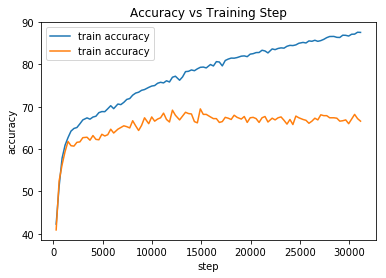

In [52]:
plt.plot(step_record, train_acc_record, label = 'train accuracy')
plt.plot(step_record, val_acc_record, label = 'train accuracy')
plt.legend()
plt.title("Accuracy vs Training Step")
plt.xlabel("step")
plt.ylabel("accuracy")
plt.savefig("result/rnn_acc_hs200_ls200.pdf")
plt.show()

Multiply the two presentation

In [47]:
class GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, vocab_size, pretrained_weight):
        """
        GRU accepts the following hyperparams:
        input_size - The number of expected features of in the input x
        hidden_size - The number of features in the hidden state h
        num_layers - Here we use the Default:1
        bias - True
        batch_first - The input and output tensors are provided as (batch, seq, feature)
        bidirectional - 
        ===================================================================================
        Note: padding_idx = 0
        """
        super(GRU, self).__init__()
        
        layer_size2 = 20
        
        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx = 0)
        self.embedding.weight.data.copy_(torch.from_numpy(pretrained_weight))
        self.gru = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional = True) # The first dimension is the batch dimension
        self.linear1 = nn.Linear(2*hidden_size, layer_size2)
        self.linear2 = nn.Linear(layer_size2, num_classes)

    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        hidden = torch.randn(2*self.num_layers, batch_size, self.hidden_size)

        return hidden.to(device)

    def forward(self, s1, s2, lengths):
        # reset hidden state
        batch_size, seq_len = s1.size()

        self.hidden_s1 = self.init_hidden(batch_size)
        self.hidden_s2 = self.init_hidden(batch_size)
        
        embed_s1 = self.embedding(s1)
        embed_s2 = self.embedding(s2)
    
        rnn_out_s1, self.hidden_s1 = self.gru(embed_s1, self.hidden_s1)
        rnn_out_s2, self.hidden_s2 = self.gru(embed_s2, self.hidden_s2)
        
        rnn_out_s1 = torch.sum(rnn_out_s1, dim=1)
        rnn_out_s2 = torch.sum(rnn_out_s2, dim=1)
        
        rnn_out = rnn_out_s1 * rnn_out_s2
        
        rnn_out = self.linear1(rnn_out)
        rnn_out = F.relu(rnn_out)
        logits = self.linear2(rnn_out)
        
        return logits



In [48]:
model = GRU(emb_size=300, hidden_size=200, num_layers=1, num_classes=3, 
            vocab_size=len(id2token), pretrained_weight = pre_emb_matrix).to(device)
result_FILE = 'result/rnn_hs200_add.p'

In [49]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

6484783


In [62]:
learning_rate = 3e-4
num_epochs = 10 # number epoch to train

val_acc_record = []
train_acc_record = []
val_loss_record = []
train_loss_record = []
step_record = []

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)

for epoch in range(num_epochs):
    for i, (s1, s2, lengths, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        # Forward pass
        outputs = model(s1.to(device), s2.to(device), lengths.to(device))
        loss = criterion(outputs, labels.to(device))

        # Backward and optimize
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 300 == 0:
            # validate
            val_acc, val_loss = test_model2(val_loader, model)
            val_acc_record.append(val_acc)
            val_loss_record.append(val_loss)
            train_acc, train_loss = test_model2(train_loader, model)
            train_acc_record.append(train_acc)
            train_loss_record.append(train_loss)
            step_record.append( i + epoch * total_step)
            print('Epoch: [{}/{}], Step: [{}/{}], Val_Acc: {}, Train_Acc: {}, Val_loss: {}, Train_loss: {}'.format(
                       epoch+1, num_epochs, i+1, len(train_loader), val_acc, train_acc, val_loss, train_loss))

training_curve = zip(step_record, train_acc_record, train_loss_record, val_acc_record, val_loss_record)
pkl.dump(training_curve, open(result_FILE, "wb"))

Epoch: [1/10], Step: [301/3125], Val_Acc: 33.1, Train_Acc: 33.16, Val_loss: 1.1035100929439068, Train_loss: 1.103185442085266
Epoch: [1/10], Step: [601/3125], Val_Acc: 33.1, Train_Acc: 33.164, Val_loss: 1.1006201580166817, Train_loss: 1.1011054068374633
Epoch: [1/10], Step: [901/3125], Val_Acc: 33.1, Train_Acc: 33.182, Val_loss: 1.0997655615210533, Train_loss: 1.0999165306091307
Epoch: [1/10], Step: [1201/3125], Val_Acc: 33.1, Train_Acc: 33.167, Val_loss: 1.0998134687542915, Train_loss: 1.0994847689819336
Epoch: [1/10], Step: [1501/3125], Val_Acc: 33.1, Train_Acc: 33.163, Val_loss: 1.09901949390769, Train_loss: 1.0991282250213623
Epoch: [1/10], Step: [1801/3125], Val_Acc: 33.1, Train_Acc: 33.17, Val_loss: 1.0990152768790722, Train_loss: 1.0987879649734498


KeyboardInterrupt: 

In [1]:
3e-4

0.0003